In [20]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [21]:
#import useful functions from sripts folder
import sys
sys.path.append("../scripts/")
from features import feature_scaling
df = pd.read_csv("../data/clean.csv")
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [22]:
#data = feature_scaling(df,'diagnosis')
#data.head()

In [23]:
data.shape

In [24]:
#range(1,26)

In [25]:

#data.columns.to_list()

Because mean and worst are strongly positively correlated we drop those columns for the first round of training

We also drop se to train model in small batches

In [26]:
!pip install causalgraphicalmodels

In [27]:
import dowhy
from causalgraphicalmodels import CausalGraphicalModel
from sklearn.model_selection import train_test_split
import pandas as pd
import sys
sys.path.append("../scripts/")
#from plot import plot_distribution
import warnings
warnings.filterwarnings('ignore')
from dowhy import CausalModel
from IPython.display import Image, display

In [28]:
from graphviz import Digraph
import pydotplus

In [29]:
data['low_radius'] = data['radius_mean'].apply(lambda x: True if x < 18 else False)

In [30]:
train,test = train_test_split(data,test_size=0.2)

In [31]:
train_features = {'diagnosis','radius','area','perimeter','compactness','smoothness','concave_points','concavity'}
train_columns = [col for col in data 
                      if any(feature in col for feature in train_features)]
train_columns

['diagnosis',
 'radius_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'low_radius']

In [32]:
training = data[train_columns]
training = training.drop(training.filter(regex = '_worst').columns,axis=1)
training = training.drop(training.filter(regex = '_se').columns,axis=1)
training.rename(columns={'concave_points_worst':'concave_points_mean'},inplace=True)
training.head()

,diagnosis,radius_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,low_radius
0,1,1.097064,1.269934,0.984375,1.568466,3.283515,2.652874,True
1,1,1.829821,1.685955,1.908708,-0.826962,-0.487072,-0.023846,True
2,1,1.579888,1.566503,1.558884,0.942210,1.052926,1.363478,True
3,1,-0.768909,-0.592687,-0.764464,3.283553,3.402909,1.915897,True
4,1,1.750297,1.776573,1.826229,0.280372,0.539340,1.371011,True


In [33]:
causal_graph = """
digraph{
radius_mean;
perimeter_mean;
area_mean;
smoothness_mean;
compactness_mean;
concavity_mean;
concave_points_mean;
U[label="Unobserved Confounders"];
radius_mean -> perimeter_mean;radius_mean -> area_mean;radius_mean -> smoothness_mean;radius_mean->low_radius;area_mean->compactness_mean;
perimeter_mean->compactness_mean;concave_points_mean->concavity_mean;
U->compactness_mean;U->smoothness_mean;U->concavity_mean;U->low_radius;U->diagnosis;
compactness_mean->diagnosis;smoothness_mean->diagnosis;concavity_mean->diagnosis;low_radius->diagnosis;
}
"""

In [34]:
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='low_radius',
        outcome='diagnosis')

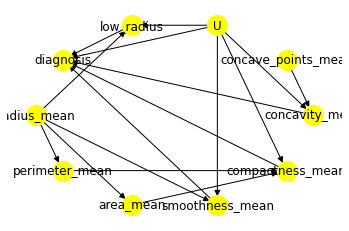

In [35]:
model.view_model()
#display(Image(filename="causal_model.png"))

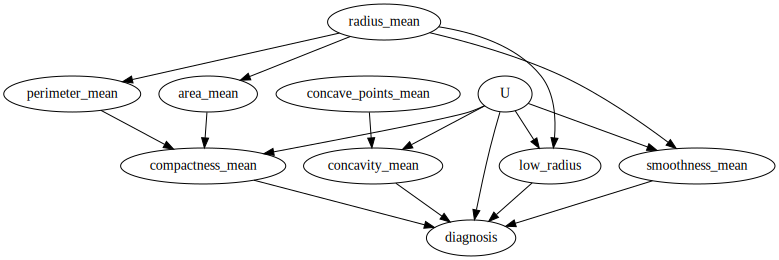

In [36]:
#area and perimeter functions of radius
from causalgraphicalmodels import CausalGraphicalModel
causal = CausalGraphicalModel(
    nodes=['radius_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean',
           'concave_points_mean','diagnosis','low_radius','U'],
    edges=[
        ("radius_mean", "perimeter_mean"), 
        ("radius_mean", "area_mean"),
        ("radius_mean","smoothness_mean"),
        ("radius_mean","low_radius"),
        ("area_mean","compactness_mean"),
        ("perimeter_mean","compactness_mean"),
        ("concave_points_mean","concavity_mean"),
        ("U","compactness_mean"),
        ("U","smoothness_mean"),
        ("U","concavity_mean"),
        ("U","low_radius"),
        ("U","diagnosis"),
        ("low_radius","diagnosis"),
        ("smoothness_mean","diagnosis"),
        ("concavity_mean","diagnosis"),
        ("compactness_mean","diagnosis")
    ]
)
# draw return a graphviz `dot` object, which jupyter can render
causal.draw()


Identify the Causal Effect

In [37]:

estimands = model.identify_effect()
print(estimands)

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(diagnosis|radius_mean,compactness_mean,perimeter_mea
d[low_radius]                                                                 

                                            
n,smoothness_mean,area_mean,concavity_mean))
                                            
Estimand assumption 1, Unconfoundedness: If U→{low_radius} and U→diagnosis then P(diagnosis|low_radius,radius_mean,compactness_mean,perimeter_mean,smoothness_mean,area_mean,concavity_mean,U) = P(diagnosis|low_radius,radius_mean,compactness_mean,perimeter_mean,smoothness_mean,area_mean,concavity_mean)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand na

Estimate the Causal Effect based on the different methods

In [38]:
#Logistic regression estimate
import statsmodels.api as sm
causal_estimate = model.estimate_effect(estimands,
                                        method_name="backdoor.generalized_linear_model",
                                       confidence_intervals=False,
                                       test_significance=False,
                                        method_params = {
                                            'num_null_simulations':10,
                                            'num_simulations':10,
                                            'num_quantiles_to_discretize_cont_cols':10,
                                            'fit_method': "statsmodels",
                                            'glm_family': sm.families.Binomial(), # logistic regression
                                            'need_conditional_estimates':False
                                        },
                                       )
print(causal_estimate)

KeyError: "['concave_points_mean'] not in index"


From the result above, we can say that the probability of a breast tumor being diagnosed as benign increases by -14.5%, when the radius mean is less than 18

In [39]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(estimands,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)

print("Causal Estimate is " + str(estimate.value))
data_1 = data[data["diagnosis"]==1]
data_0 = data[data["diagnosis"]==0]
import numpy as np
print("ATE", np.mean(data_1["radius_worst"])- np.mean(data_0["radius_worst"]))

KeyError: "['concave_points_mean'] not in index"

In [ ]:
#Logistic regression estimate
import statsmodels.api as sm
causal_estimate = model.estimate_effect(estimands,
                                        method_name="backdoor.generalized_linear_model",
                                       confidence_intervals=False,
                                       test_significance=False,
                                        method_params = {
                                            'num_null_simulations':10,
                                            'num_simulations':10,
                                            'num_quantiles_to_discretize_cont_cols':10,
                                            'fit_method': "statsmodels",
                                            'glm_family': sm.families.Binomial(), # logistic regression
                                            'need_conditional_estimates':False
                                        },
                                       )
print(causal_estimate)